In [1]:
pip install torch torchvision diffusers transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 31.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

100%|██████████| 9.91M/9.91M [00:00<00:00, 14.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 475kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.36MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.42MB/s]


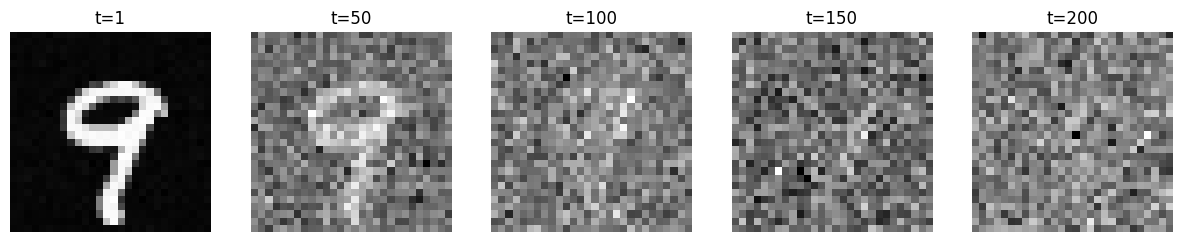

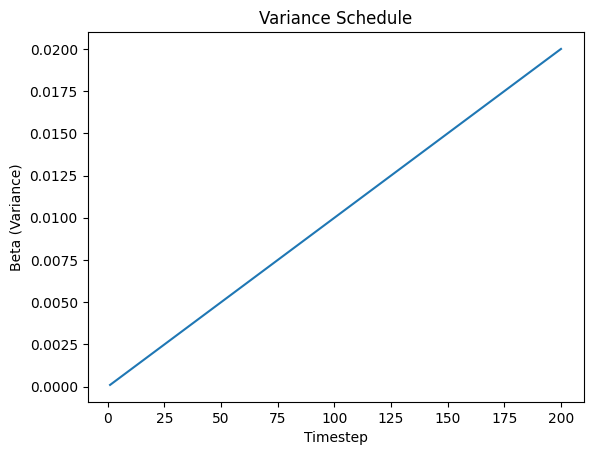

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(mnist, batch_size=1, shuffle=True)
images, _ = next(iter(loader))
x0 = images[0]

# Define beta schedule
T = 200
beta_start = 1e-4
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)

# Function to add noise
def q_sample(x0, t):
    noise = torch.randn_like(x0)
    sqrt_alpha_bar = torch.sqrt(alpha_bar[t])[:, None, None, None]
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar[t])[:, None, None, None]
    return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise

# Visualize samples at specific timesteps
timesteps = [1, 50, 100, 150, 200]
fig, axs = plt.subplots(1, len(timesteps), figsize=(15, 3))
for i, t in enumerate(timesteps):
    xt = q_sample(x0, torch.tensor([t-1]))
    axs[i].imshow(xt[0][0], cmap='gray')
    axs[i].set_title(f"t={t}")
    axs[i].axis('off')
plt.show()

# Plot variance vs timestep
plt.plot(range(1, T+1), beta.numpy())
plt.xlabel('Timestep')
plt.ylabel('Beta (Variance)')
plt.title('Variance Schedule')
plt.show()


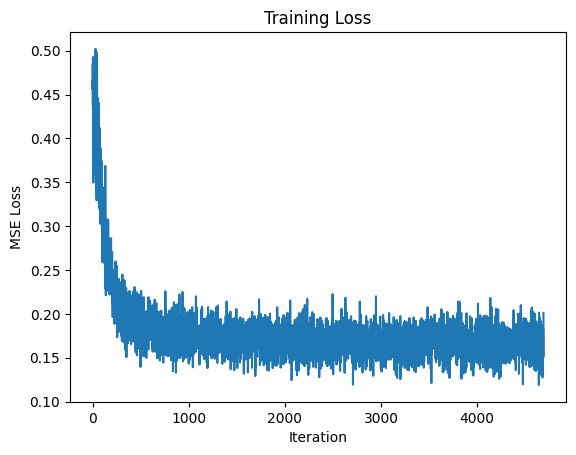

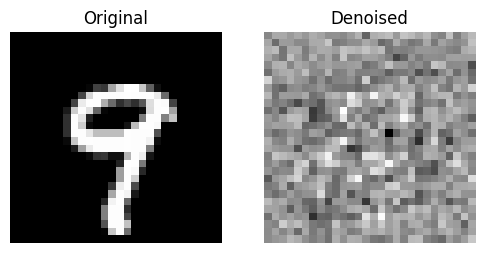

In [3]:
import torch.nn as nn
import torch.optim as optim

# Define a simple MLP model
class DenoiseMLP(nn.Module):
    def __init__(self):
        super(DenoiseMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28 + 1, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28)
        )

    def forward(self, x, t):
        t = t.float() / T
        t = t.unsqueeze(1)
        x = x.view(x.size(0), -1)
        x = torch.cat([x, t], dim=1)
        return self.model(x)

# Prepare data
batch_size = 64
loader = torch.utils.data.DataLoader(mnist, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
model = DenoiseMLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 5
losses = []
for epoch in range(epochs):
    for images, _ in loader:
        t = torch.randint(0, T, (images.size(0),))
        xt = q_sample(images, t)
        noise = xt - images
        optimizer.zero_grad()
        output = model(xt, t)
        loss = criterion(output, noise.view(images.size(0), -1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

# Plot training loss
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Denoise a sample image
with torch.no_grad():
    xt = q_sample(x0.unsqueeze(0), torch.tensor([T-1]))
    for t_step in reversed(range(T)):
        noise_pred = model(xt, torch.tensor([t_step]))
        xt = xt - noise_pred.view(1, 1, 28, 28)

    # Show original and denoised images
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(x0[0], cmap='gray')
    axs[0].set_title("Original")
    axs[0].axis('off')
    axs[1].imshow(xt[0][0], cmap='gray')
    axs[1].set_title("Denoised")
    axs[1].axis('off')
    plt.show()


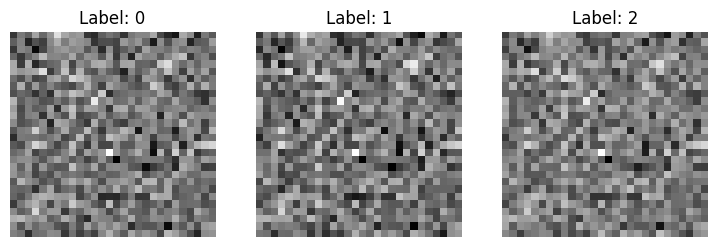

In [4]:
# Modify the model to accept class labels
class ConditionalDenoiseMLP(nn.Module):
    def __init__(self):
        super(ConditionalDenoiseMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28 + 1 + 10, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28)
        )

    def forward(self, x, t, y):
        t = t.float() / T
        t = t.unsqueeze(1)
        x = x.view(x.size(0), -1)
        x = torch.cat([x, t, y], dim=1)
        return self.model(x)

# Initialize model
cond_model = ConditionalDenoiseMLP()

# Generate images conditioned on labels 0, 1, 2
from torchvision.utils import make_grid

cond_model.eval()
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i, label in enumerate([0, 1, 2]):
    y = torch.zeros(1, 10)
    y[0, label] = 1
    xt = torch.randn(1, 1, 28, 28)
    for t_step in reversed(range(T)):
        noise_pred = cond_model(xt, torch.tensor([t_step]), y)
        xt = xt - noise_pred.view(1, 1, 28, 28)
    axs[i].imshow(xt[0][0].detach().numpy(), cmap='gray')
    axs[i].set_title(f"Label: {label}")
    axs[i].axis('off')
plt.show()


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

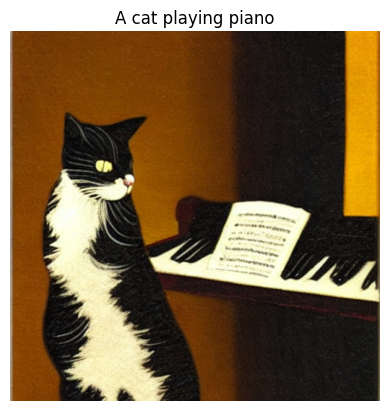

  0%|          | 0/50 [00:00<?, ?it/s]

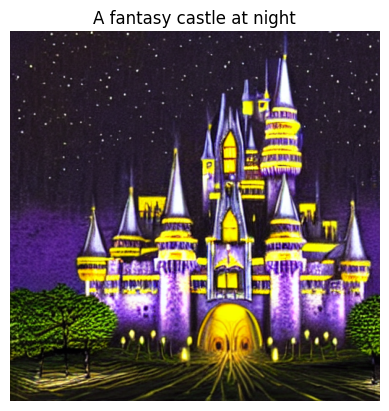

In [ ]:
from diffusers import StableDiffusionPipeline
import torch
import matplotlib.pyplot as plt

# Load the pipeline
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

# Define prompts
prompts = ["A cat playing piano", "A fantasy castle at night"]

# Generate and display images
for prompt in prompts:
    image = pipe(prompt).images[0]
    plt.imshow(image)
    plt.title(prompt)
    plt.axis('off')
    plt.show()
